# VGG16 - TOBACCO - PSS One Page

Trying to reproduce the expirement from [here](https://github.com/uhh-lt/pss-lrev/blob/master/exp2_img-only_Tobacco800.ipynb)

### Data Processing

As always, we'll import the modules we need. No new imports yet.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import _LRScheduler
from torch import optim
import torch.utils.data as data

import timm
from timm.optim import optim_factory
from types import SimpleNamespace

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
from PIL import Image

from skimage import io, transform
import cv2

We'll also set the random seeds.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

Here we define a model 

In [3]:
class SinglePageModel(nn.Module):
    def __init__(self, features, n_classes):
        super().__init__()
        
        self.features = features
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),            
            nn.Linear(512 * 7 * 7, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(), 
            nn.Dropout(0.5),
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

In [5]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

Now, let's get the `features` for the VGG16 architecture, without batch normalization, as Wiedmann used.

In [6]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm = False)

We can then pass these `features` to our base VGG module to get our VGG16 model.

In [7]:
OUTPUT_DIM = 2

model = SinglePageModel(vgg16_layers, OUTPUT_DIM)

### Pre-trained Model Load

In [8]:
pretrained_model = models.vgg16(pretrained = True)

In [9]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

We must clear VGG pretrained_dict before load it into SinglePageModel, since they have different layers.

In [10]:
def clean_pretrained_dict(model_dict, pretrained_dict):

    # filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    
    # overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    
    return model_dict

In [11]:
model_dict = clean_pretrained_dict(model.state_dict(),pretrained_model.state_dict()) 

...loading state dict from pre-trained into model

In [12]:
model.load_state_dict(model_dict, strict=False)

<All keys matched successfully>

### Freezing Model Layers
The experiment presented at the paper they froze all VGG CNN layers, but the last. As we did with the following code.

In [13]:
for name, parameter in model.features.named_parameters():
    if not name.startswith('28'):
        parameter.requires_grad = False

### Data Processing

In [14]:
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]
pretrained_size = (224,224)

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

transform = transforms.Compose([
                            ResizeBinarize(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

Setting the path of images and csvs

pretrained_size = (224,224)
 transforms.Resize(pretrained_size),

In [15]:
PAGE_IMGS_PATH = '/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw/'
TRAIN_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/train.csv'
TEST_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/test.csv'

Loading datasets

In [16]:
df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_val = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False) 

In [17]:
class TobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        label2Idx = {'FirstPage' : 1, 'NextPage' : 0}
        if type(index) != int:
            i = index.item()
        else: i = index
        row = self.dataframe.iloc[i]
        file_name = row["docid"]+'.tif'
        img = io.imread(self.root_dir+file_name,plugin='pil')
        
        if self.transform:
            img = self.transform(img)
        
        return (
            img,
            label2Idx[row["class"]],
            file_name
        )

In [18]:
train_data = TobaccoDataset(df_train,PAGE_IMGS_PATH, transform )

valid_data = TobaccoDataset(df_val,PAGE_IMGS_PATH, transform )

We'll print out the number of examples in each split to ensure they are correct.

In [19]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 1031
Number of validation examples: 259


We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [20]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)
         
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
#        ax.set_title(labels[i])
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

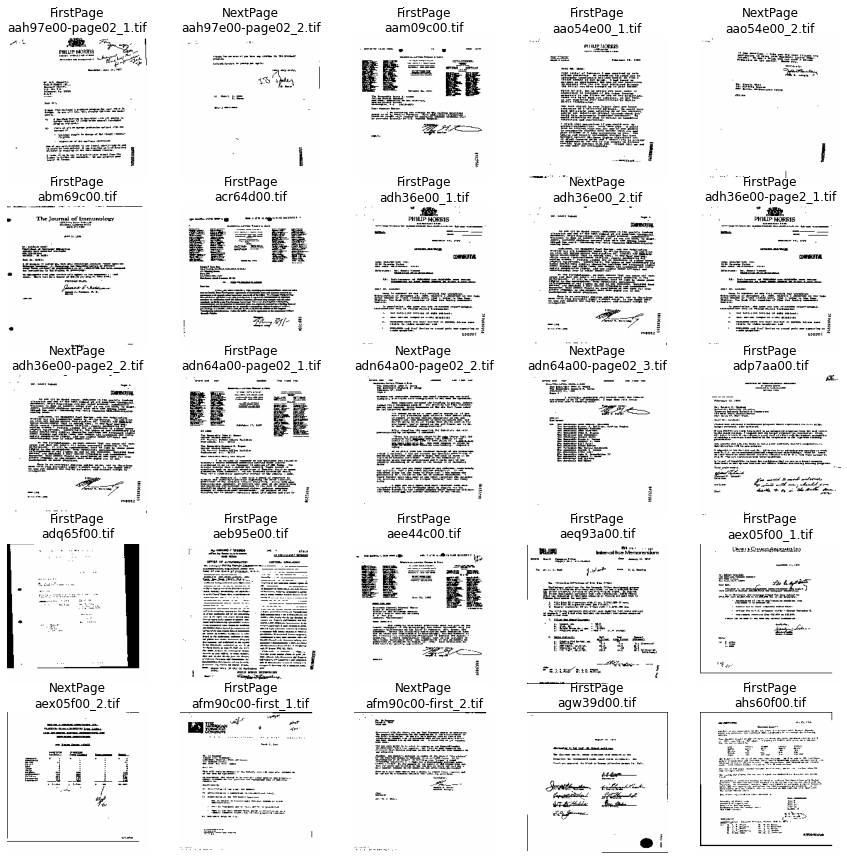

In [21]:
N_IMAGES = 25

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {1: 'FirstPage', 0: 'NextPage'}

plot_images(images, labels, classes, file_names)

As the model is ~5x the size of the AlexNet model from the previous notebook we use a smaller batch size so it can fit on reasonably sized GPUs. This should be increased if we have access to GPUs with more memory in order to speed up training.

In [22]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE, shuffle=False)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [23]:
args = SimpleNamespace()
args.weight_decay = 0 
args.lr = 0.00005
args.opt="Nadam"

optimizer = optim_factory.create_optimizer(args,model)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda:1


In [24]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [25]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_kappa += kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...create a function that performs an evaluation loop...

In [26]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, name) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)
        
            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_kappa += kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...and a helper function to tell us how long an epoch takes.

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

We get ~94% validation accuracy in only five epochs.

In [155]:
EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'new-model2.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 0.647 | Train Acc: 62.53% | Train Kappa: 13.04%
	 Val. Loss: 0.575 |  Val. Acc: 81.94% |  Val. Kappa: 63.49%
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 0.530 | Train Acc: 81.80% | Train Kappa: 57.95%
	 Val. Loss: 0.506 |  Val. Acc: 81.71% |  Val. Kappa: 63.84%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.458 | Train Acc: 86.55% | Train Kappa: 68.56%
	 Val. Loss: 0.499 |  Val. Acc: 81.37% |  Val. Kappa: 63.42%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.428 | Train Acc: 89.68% | Train Kappa: 75.13%
	 Val. Loss: 0.436 |  Val. Acc: 89.58% |  Val. Kappa: 78.68%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.396 | Train Acc: 92.80% | Train Kappa: 81.84%
	 Val. Loss: 0.411 |  Val. Acc: 90.97% |  Val. Kappa: 81.45%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.392 | Train Acc: 92.42% | Train Kappa: 80.61%
	 Val. Loss: 0.410 |  Val. Acc: 89.93% |  Val. Kappa: 79.36%
Epoch: 07 | Epoch Time: 0m 46s
	Train Loss: 0.375 | Train Acc: 94.51% | Train Kapp

Our test accuracy is a little lower at ~92%, but is still higher than the ~75% achieved by the AlexNet model in the previous tutorial notebook.

In [28]:
model.load_state_dict(torch.load('new-model2.pt'))

test_loss, test_acc, test_kappa = evaluate(model, valid_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |  Test. Kappa: {test_kappa*100:.2f}%')

Test Loss: 0.394 | Test Acc: 91.67% |  Test. Kappa: 82.84%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [81]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            file_names.append(name)

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = [item for sublist in file_names for item in sublist]

    return images, labels, probs, file_names

In [82]:
images, labels, probs, file_names = get_predictions(model, valid_iterator)

...then get the predicted labels for each image...

In [39]:
pred_labels = torch.argmax(probs, 1)

In [58]:
pred_labels

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [59]:
labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

...and then use these predictions to create a confusion matrix.

In [40]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

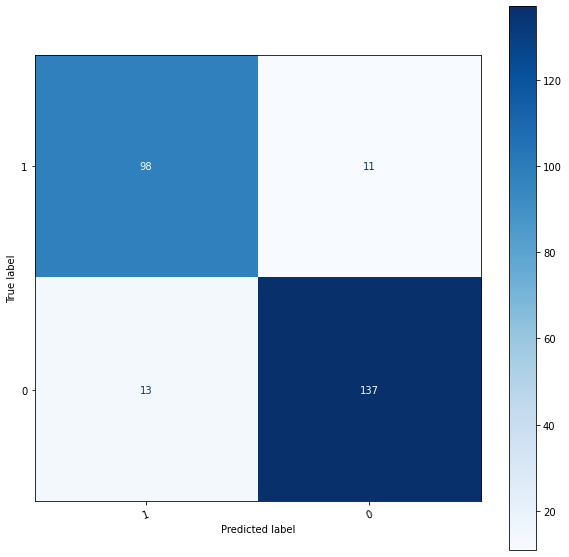

In [41]:
plot_confusion_matrix(labels, pred_labels, classes)

We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [42]:
corrects = torch.eq(labels, pred_labels)

In [84]:
incorrect_examples = []

for image, label, prob, correct, file_name in zip(images, labels, probs, corrects, file_names):
    if not correct:
        incorrect_examples.append((image, label, prob, file_name))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [89]:
def plot_most_incorrect(incorrect, classes, n_images, file_names, normalize = True):

    rows = int(np.sqrt(n_images)) 
    cols = int(np.sqrt(n_images)) -1

    fig = plt.figure(figsize = (30, 25))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs, file_name = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        
        true_class = classes[true_label if type(true_label)==int else true_label.item()]
        incorrect_class = classes[incorrect_label if type(true_label)==int else incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})\n' \
                     f'file: {file_name}\n')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

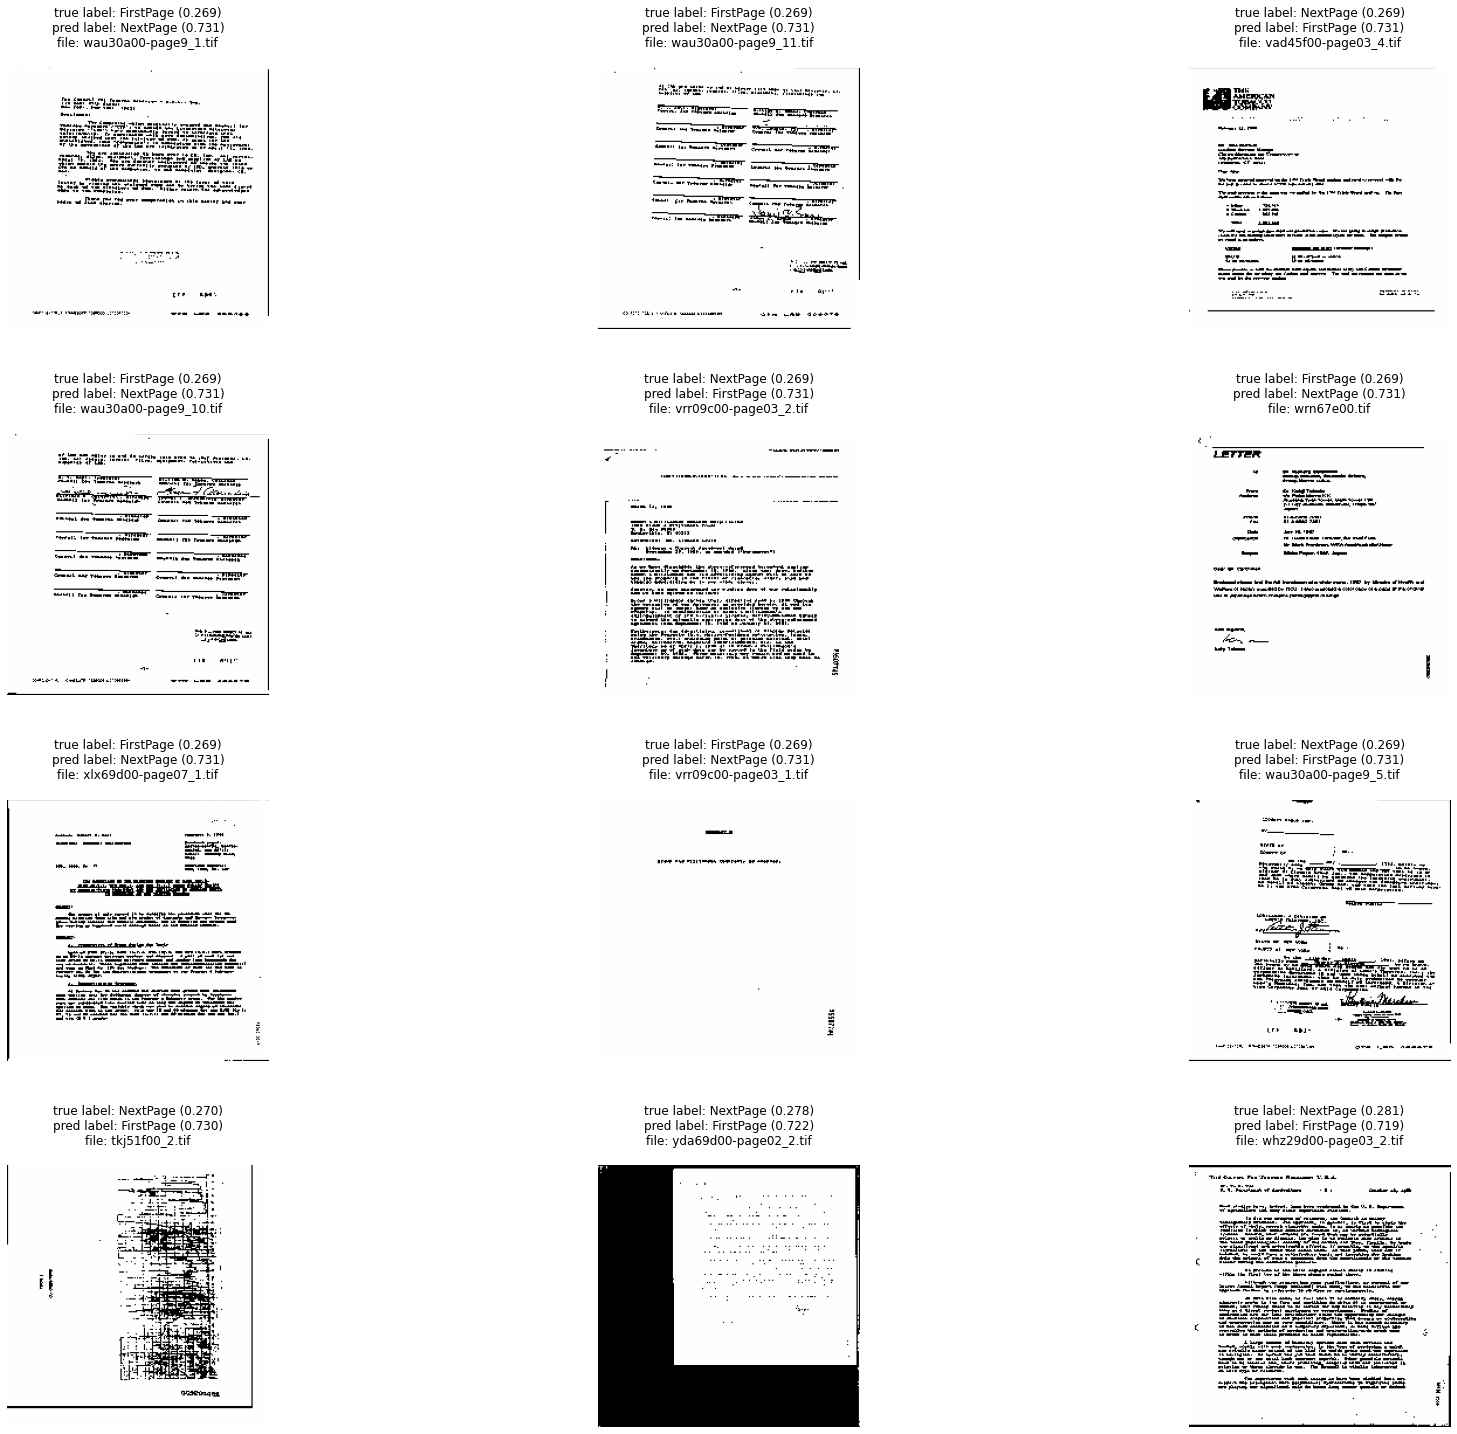

In [90]:
N_IMAGES = 36 if len(incorrect_examples) >= 36 else len(incorrect_examples)
classes = {1: 'FirstPage', 0: 'NextPage'}
plot_most_incorrect(incorrect_examples, classes, N_IMAGES, file_names)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are ten dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [93]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y, _) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [94]:
outputs, labels = get_representations(model, train_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [95]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [96]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

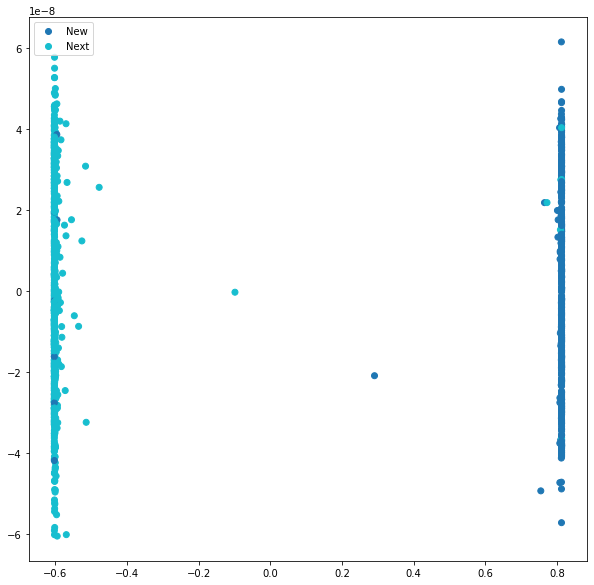

In [97]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, ['New','Next'])

Next up is calculating the t-SNE representations.

In [98]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

As mentioned in previous notebooks t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

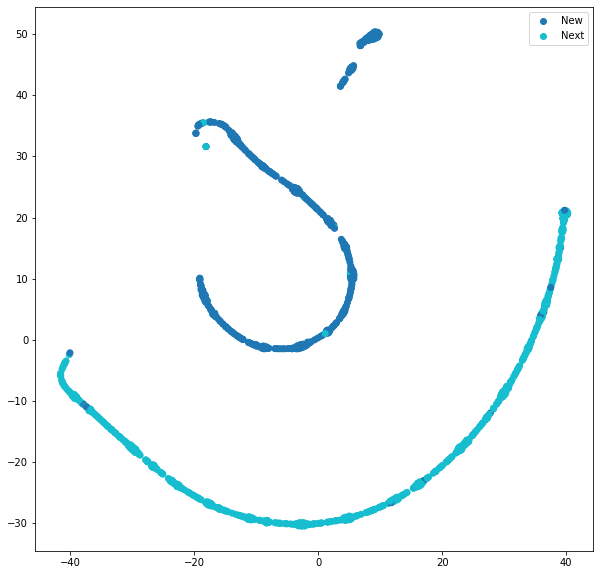

In [99]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, ['New','Next'], n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [100]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

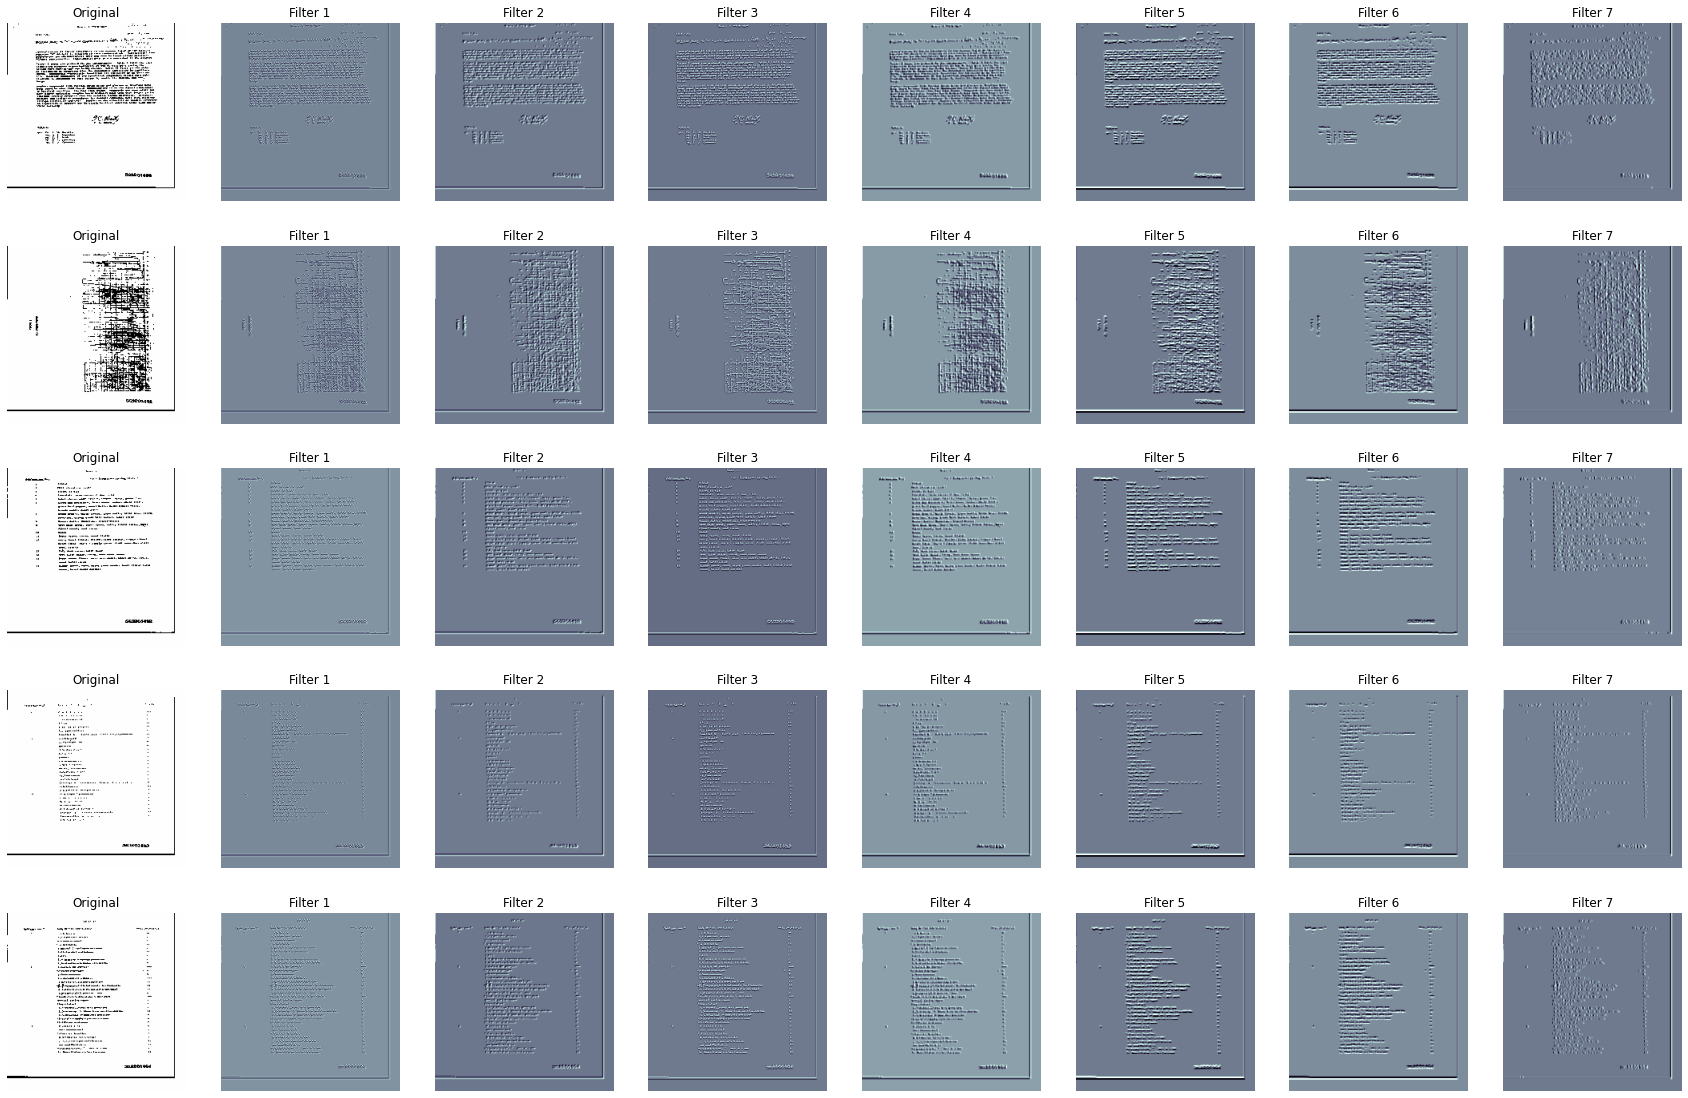

In [103]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label, _ in [valid_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can also plot out the actual filter weights learned by the model.

In [104]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

Even though these aren't as interpretable as the pre-trained AlexNet filters shown in the previous notebook, they are more interesting than the AlexNet filters learned from scratch. 

Interestingly there are multiple filters that are completely black, implying they all have filters weights that are basically zero.

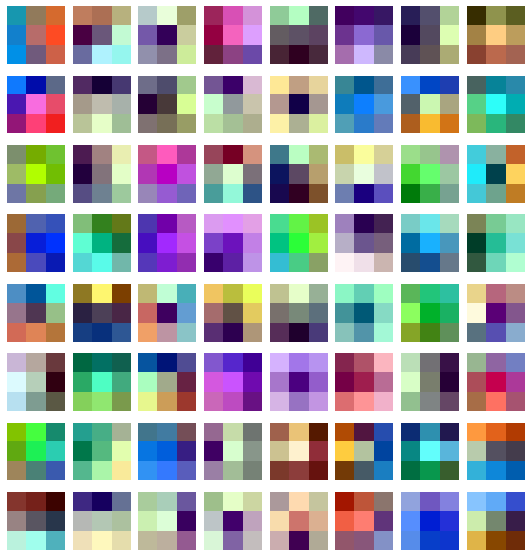

In [105]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (VGG)
- adaptive pooling
- batch normalization
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to freeze weights of our model
- how to use the learning rate finder
- how to use discriminative fine-tuning
- fine-tuning a pre-trained model to achieve >94% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model

In the next notebook we'll implement yet another popular CNN architecture, ResNet, and learn about how to pre-trained models ourselves using self-supervised learning.